# Loading required libraries

In [ ]:
import pandas as pd
import seaborn as sns
import geopy
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split,RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_auc_score,roc_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
import graphviz


# Load data

In [ ]:
df = pd.read_csv('acceleration_data.csv')

In [ ]:
df.head()

,ID,GEO_X,GEO_Y,SECTOR,EMPLOYEES,INCOME,MARKETING_SPENDING,ACC_BEFORE,PWC_PRESS_INDEX,FB_LIKES,TWT_FOLLOWERS,YEAR_FOUNDED,EXP_CEO,AREA,PWC_EMPLOYEES,CREDIT,FLAG
0,1,21.001716,52.231406,PUB,2,150426.0,7964,0,-8.078335,1633,138,2010,NaN,32,0,19950,0
1,2,21.006869,52.233266,PUB,6,500078.0,30212,0,17.032851,6128,605,2011,NaN,44,1,45104,1
2,3,21.074607,52.279005,IT,27,199767.0,4970,0,-7.321621,487,106,2005,NaN,83,0,499,0
3,4,21.012082,52.232082,IT,5,109200.0,7010,1,1.135431,661,116,2011,NaN,21,1,0,1
4,5,21.000125,52.239957,IT,3,112200.0,9000,0,0.950873,926,172,2012,5.0,23,0,-997,1


## Delete unnecessary feature

In [ ]:
df.drop(labels=['ID'],axis=1,inplace=True)

### Dataset size

In [ ]:
print('Data set contains {} observations, described by {} features.'.format(df.shape[0], df.shape[1]))

Data set contains 10000 observations, described by 16 features.


## Some information about Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GEO_X               10000 non-null  float64
 1   GEO_Y               10000 non-null  float64
 2   SECTOR              10000 non-null  object 
 3   EMPLOYEES           10000 non-null  int64  
 4   INCOME              10000 non-null  float64
 5   MARKETING_SPENDING  10000 non-null  int64  
 6   ACC_BEFORE          10000 non-null  int64  
 7   PWC_PRESS_INDEX     10000 non-null  float64
 8   FB_LIKES            10000 non-null  int64  
 9   TWT_FOLLOWERS       10000 non-null  int64  
 10  YEAR_FOUNDED        10000 non-null  int64  
 11  EXP_CEO             5603 non-null   float64
 12  AREA                10000 non-null  int64  
 13  PWC_EMPLOYEES       10000 non-null  int64  
 14  CREDIT              10000 non-null  int64  
 15  FLAG                10000 non-null  int64  
dtypes: fl

In [ ]:
df.isnull().sum()

GEO_X                    0
GEO_Y                    0
SECTOR                   0
EMPLOYEES                0
INCOME                   0
MARKETING_SPENDING       0
ACC_BEFORE               0
PWC_PRESS_INDEX          0
FB_LIKES                 0
TWT_FOLLOWERS            0
YEAR_FOUNDED             0
EXP_CEO               4397
AREA                     0
PWC_EMPLOYEES            0
CREDIT                   0
FLAG                     0
dtype: int64

In [ ]:
sns.pairplot(data=df,hue="FLAG")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df.describe()

,GEO_X,GEO_Y,EMPLOYEES,INCOME,MARKETING_SPENDING,ACC_BEFORE,PWC_PRESS_INDEX,FB_LIKES,TWT_FOLLOWERS,YEAR_FOUNDED,EXP_CEO,AREA,PWC_EMPLOYEES,CREDIT,FLAG
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5603.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,21.072191,52.239125,12.956300,232443.375500,13515.335200,0.336400,-0.681005,1919.496800,270.476500,2006.907200,6.603070,91.014600,1.502500,2.775444e+05,0.526100
std,0.063102,0.036902,15.100622,137466.555775,12037.821285,0.472501,8.357843,1829.979996,241.681628,4.612973,3.117685,95.869246,1.852225,1.605495e+06,0.499343
min,21.000006,52.170047,1.000000,-900.000000,830.000000,0.000000,-38.793253,91.000000,16.000000,1989.000000,1.000000,11.000000,0.000000,-9.830000e+03,0.000000
25%,21.018441,52.216754,3.000000,149647.000000,5136.750000,0.000000,-5.040576,542.000000,118.000000,2004.000000,4.000000,31.000000,0.000000,0.000000e+00,0.000000
50%,21.051393,52.231780,5.000000,199734.000000,8038.000000,0.000000,-1.186027,1223.000000,165.000000,2007.000000,6.000000,63.000000,1.000000,1.207000e+03,1.000000
75%,21.136338,52.277630,21.000000,312862.500000,11970.000000,1.000000,2.676324,1656.000000,232.250000,2011.000000,8.000000,75.000000,2.000000,2.105125e+04,1.000000
max,21.199989,52.299988,63.000000,647000.000000,68180.000000,1.000000,59.938575,6893.000000,1410.000000,2014.000000,21.000000,387.000000,15.000000,1.313101e+07,1.000000


In [ ]:
df.head()

,GEO_X,GEO_Y,SECTOR,EMPLOYEES,INCOME,MARKETING_SPENDING,ACC_BEFORE,PWC_PRESS_INDEX,FB_LIKES,TWT_FOLLOWERS,YEAR_FOUNDED,EXP_CEO,AREA,PWC_EMPLOYEES,CREDIT,FLAG
0,21.001716,52.231406,PUB,2,150426.0,7964,0,-8.078335,1633,138,2010,NaN,32,0,19950,0
1,21.006869,52.233266,PUB,6,500078.0,30212,0,17.032851,6128,605,2011,NaN,44,1,45104,1
2,21.074607,52.279005,IT,27,199767.0,4970,0,-7.321621,487,106,2005,NaN,83,0,499,0
3,21.012082,52.232082,IT,5,109200.0,7010,1,1.135431,661,116,2011,NaN,21,1,0,1
4,21.000125,52.239957,IT,3,112200.0,9000,0,0.950873,926,172,2012,5.0,23,0,-997,1


In [ ]:
df["FLAG"].value_counts(normalize = True)

1    0.5261
0    0.4739
Name: FLAG, dtype: float64

 Balanced Dataset contains around 50/50

#### Checking localization 

In [ ]:
"""df['GEO_X'] = df['GEO_X'].astype(str)
df['GEO_Y'] = df['GEO_Y'].astype(str)"""

"df['GEO_X'] = df['GEO_X'].astype(str)\ndf['GEO_Y'] = df['GEO_Y'].astype(str)"

In [ ]:
"""df=df.head(30)
geolocator = Nominatim(user_agent="My_geolocate")
for x, y in zip(df["GEO_X"], df["GEO_Y"]):
    print(x+","+y)
    location = geolocator.reverse(x+","+y)
    locations = geolocator.geocode(location, language="en")

print(locations.address)"""

'df=df.head(30)\ngeolocator = Nominatim(user_agent="My_geolocate")\nfor x, y in zip(df["GEO_X"], df["GEO_Y"]):\n    print(x+","+y)\n    location = geolocator.reverse(x+","+y)\n    locations = geolocator.geocode(location, language="en")\n\nprint(locations.address)'

### Checking distrution of numeric features

In [ ]:
df_1= pd.melt(df, value_vars=df.drop
                            (['GEO_X', 'GEO_Y','FLAG', 'INCOME', 'MARKETING_SPENDING', 'FB_LIKES', 
                              'TWT_FOLLOWERS', 'YEAR_FOUNDED','CREDIT','SECTOR'], axis = 1).columns,
                            var_name=['Feature_name'], value_name = 'Value')
df_2 = pd.melt(df, value_vars=df.drop
                            (['FLAG', 'GEO_X', 'GEO_Y', 'EMPLOYEES', 
                              'ACC_BEFORE', 'PWC_PRESS_INDEX', 'EXP_CEO','AREA','SECTOR','PWC_EMPLOYEES','CREDIT','INCOME','MARKETING_SPENDING','YEAR_FOUNDED'], axis = 1).columns,
                            var_name=['Feature_name'], value_name = 'Value')
df_3= pd.melt(df, value_vars=df.drop
                            (['FLAG', 'GEO_X', 'GEO_Y', 'EMPLOYEES', 
                              'ACC_BEFORE', 'PWC_PRESS_INDEX', 'EXP_CEO','AREA','SECTOR','PWC_EMPLOYEES','FB_LIKES','TWT_FOLLOWERS','YEAR_FOUNDED','CREDIT'], axis = 1).columns,
                            var_name=['Feature_name'], value_name = 'Value')
df_4= pd.melt(df, value_vars=df.drop
                            (['GEO_X', 'GEO_Y', 'SECTOR', 'EMPLOYEES', 'INCOME', 'MARKETING_SPENDING',
       'ACC_BEFORE', 'PWC_PRESS_INDEX', 'FB_LIKES', 'TWT_FOLLOWERS',
       'YEAR_FOUNDED', 'EXP_CEO', 'PWC_EMPLOYEES', 'FLAG','AREA'], axis = 1).columns,
                            var_name=['Feature_name'], value_name = 'Value')

I am dividing this into 4 diagrams to better show the scale of features

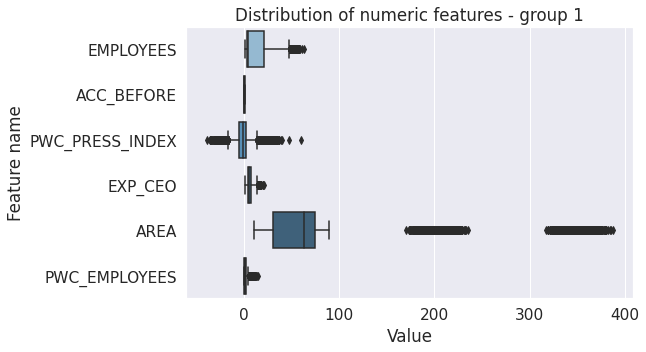

In [ ]:
plt.figure(figsize=(8,5))
sns.set(font_scale=1.4)
sns.boxplot(data = df_1, y = 'Feature_name', x = 'Value', palette = 'Blues_d').set(title = 'Distribution of numeric features - group 1', ylabel = 'Feature name')
plt.show()

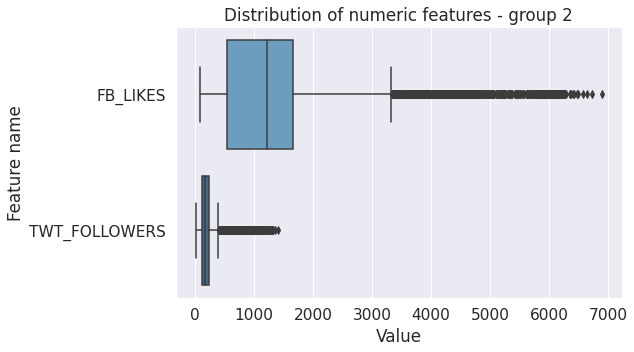

In [ ]:
plt.figure(figsize=(8,5))
sns.set(font_scale=1.4)
sns.boxplot(data = df_2, y = 'Feature_name', x = 'Value', palette = 'Blues_d').set(title = 'Distribution of numeric features - group 2', ylabel = 'Feature name')
plt.show()

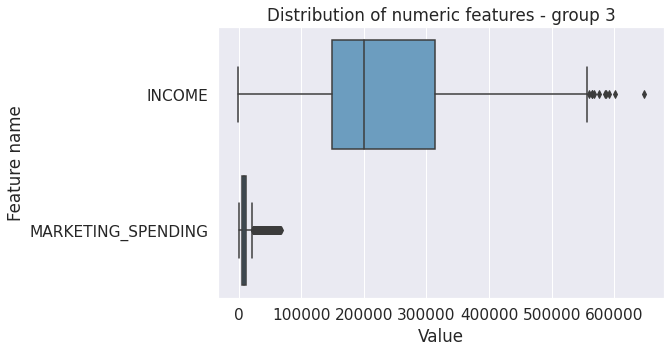

In [ ]:
plt.figure(figsize=(8,5))
sns.set(font_scale=1.4)
sns.boxplot(data = df_3, y = 'Feature_name', x = 'Value', palette = 'Blues_d').set(title = 'Distribution of numeric features - group 3', ylabel = 'Feature name')
plt.show()

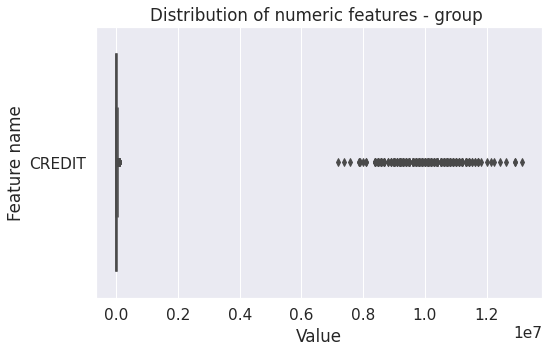

In [ ]:
plt.figure(figsize=(8,5))
sns.set(font_scale=1.4)
sns.boxplot(data = df_4, y = 'Feature_name', x = 'Value', palette = 'Blues_d').set(title = 'Distribution of numeric features - group ', ylabel = 'Feature name')
plt.show()

In the dataset we have a lot of outliers but I do not remove them because I would get a very small Dataset 

In [ ]:
df = df.fillna(df.median())

We have empty spaces only in EXP_CEO so I fill them with the median

## Correlation between variables

I will use Spearman's rank correlation, because:
- It has no assumption abour distribution of variables
- It is ranking based on values, so this method is resistant to outliers

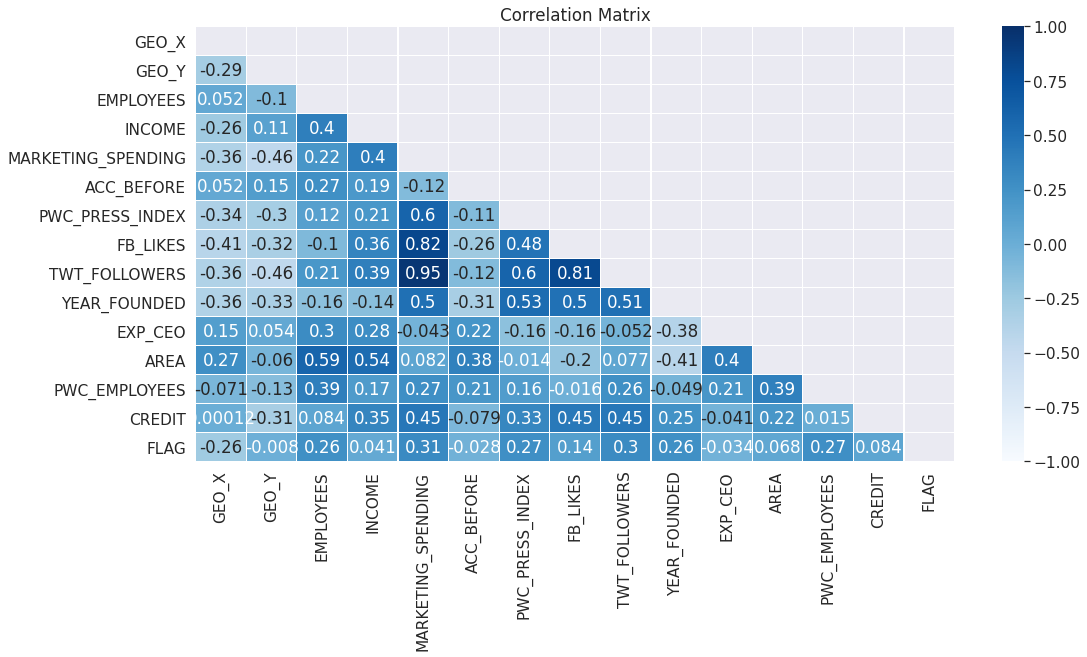

In [ ]:
plt.figure(figsize=(17,8))
corr = df.corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,linewidths=0.2,vmin=-1,vmax=1,mask=mask, cmap='Blues',center=0)
plt.title('Correlation Matrix')
plt.show()

Correlation between numeric features is quite strong in some cases:
- 'MARKETING_SPENDING' and  'TWT_FOLLOWERS'
- 'MARKETING_SPENDING' and  'FB_LIKES'
- 'FB_LIKES' and  'TWT_FOLLOWERS'

<Figure size 1224x720 with 0 Axes>

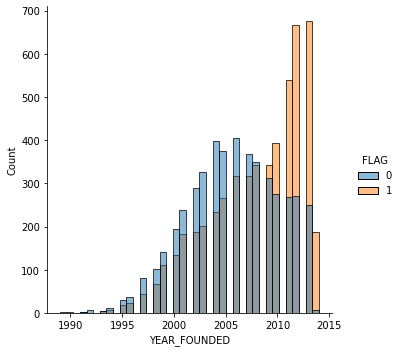

<Figure size 1224x720 with 0 Axes>

In [ ]:
sns.displot(df, x="YEAR_FOUNDED", hue="FLAG", )
plt.figure(figsize=(17,10))

Text(0.5, 1.0, 'Grouped bar plot - SECTOR & FLAG')

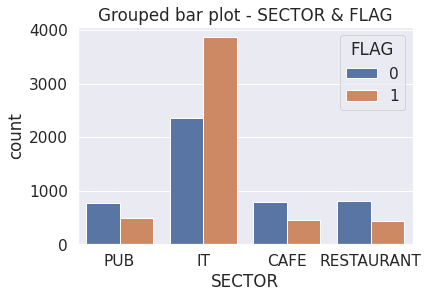

In [ ]:
sns.countplot(x='SECTOR', hue='FLAG', data=df)
plt.xlabel("SECTOR")
plt.title('Grouped bar plot - SECTOR & FLAG')

In [ ]:
df.head()

,ID,GEO_X,GEO_Y,SECTOR,EMPLOYEES,INCOME,MARKETING_SPENDING,ACC_BEFORE,PWC_PRESS_INDEX,FB_LIKES,TWT_FOLLOWERS,YEAR_FOUNDED,EXP_CEO,AREA,PWC_EMPLOYEES,CREDIT,FLAG
0,1,21.001716,52.231406,PUB,2,150426.0,7964,0,-8.078335,1633,138,2010,NaN,32,0,19950,0
1,2,21.006869,52.233266,PUB,6,500078.0,30212,0,17.032851,6128,605,2011,NaN,44,1,45104,1
2,3,21.074607,52.279005,IT,27,199767.0,4970,0,-7.321621,487,106,2005,NaN,83,0,499,0
3,4,21.012082,52.232082,IT,5,109200.0,7010,1,1.135431,661,116,2011,NaN,21,1,0,1
4,5,21.000125,52.239957,IT,3,112200.0,9000,0,0.950873,926,172,2012,5.0,23,0,-997,1


## Dataset preparation

In [ ]:
df_1=pd.get_dummies(df['SECTOR'],prefix="SECTOR_",drop_first=True)
df = pd.concat([df_1, df], axis=1)
df.drop("SECTOR",axis=1,inplace=True)

In [ ]:
X  = df.iloc[:,:-1]
y = df.iloc[:,-1]

print(X.shape)
print(y.shape)

(10000, 17)
(10000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Cross-validation

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
print("Decision Tree :",cross_val_score(clf, X, y, cv=5, scoring='f1').mean())

Decision Tree : 0.7295220928018754


In [ ]:
Rforest = RandomForestClassifier(random_state=42)
print("Random Forest :",cross_val_score(Rforest, X, y, cv=5, scoring='f1').mean())

Random Forest : 0.7756978602550533


# Basic models
### Decision Tree

0.7245
AxesSubplot(0.125,0.125;0.62x0.755)


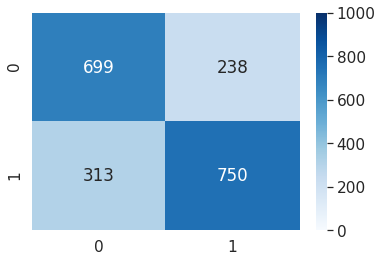

In [ ]:
clf = clf.fit(X_train, y_train)
#print(clf.feature_importances_)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(sns.heatmap(confusion_matrix(y_test,y_pred),vmin=0,vmax=1000,annot=True,cmap='Blues',fmt='g'))

### Random Forest

0.761
AxesSubplot(0.125,0.125;0.62x0.755)


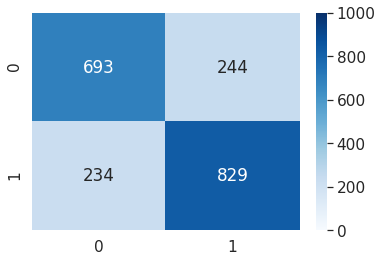

In [ ]:
Rforest = Rforest.fit(X_train, y_train)
y_pred = Rforest.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(sns.heatmap(confusion_matrix(y_test,y_pred),vmin=0,vmax=1000,annot=True,cmap='Blues',fmt='g'))

## GridSearch Decison Tree

In [ ]:
parameters = {'criterion':('entropy', 'gini'), 
              'splitter':('best','random'), 
              'max_depth':np.arange(2, 6), 
              'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(1,5)}

In [ ]:
grid = GridSearchCV(clf, parameters, cv=5,scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('entropy', 'gini'),
                     

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

0.7344999999999999
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 9, 'splitter': 'best'}


0.7515
AxesSubplot(0.125,0.125;0.62x0.755)


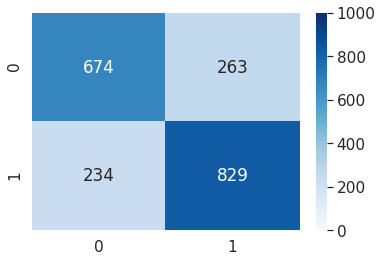

In [ ]:
clf = DecisionTreeClassifier(random_state=42,**grid.best_params_)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(sns.heatmap(confusion_matrix(y_test,y_pred),vmin=0,vmax=1000,annot=True,cmap='Blues',fmt='g'))

## GridSearch Random Forest

In [ ]:
parameters = {'n_estimators' :np.arange(100,120),
              'criterion':('entropy', 'gini'),  
              'max_depth':np.arange(2, 6), 
              'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(1,5)}

In [ ]:
grid = RandomizedSearchCV(Rforest, parameters, cv=5, scoring='accuracy',n_iter=20)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=5,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=9,
                                                    min_weight_fraction_leaf=0.0,
                  

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

0.7284999999999999
{'n_estimators': 119, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'gini'}


0.734
AxesSubplot(0.125,0.125;0.62x0.755)


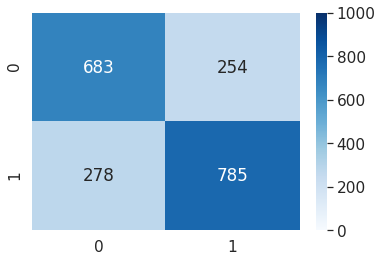

In [ ]:
Rforest = RandomForestClassifier(random_state=42,**grid.best_params_)
Rforest.fit(X_train, y_train)
y_pred = Rforest.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(sns.heatmap(confusion_matrix(y_test,y_pred),vmin=0,vmax=1000,annot=True,cmap='Blues',fmt='g'))

## XGBoost

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
xgb = XGBClassifier(random_state=42)
scores = cross_val_score(xgb, X_train, y_train, cv=5)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
kf_cv_scores = cross_val_score(xgb, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
xgb.fit(X_train,y_train)
y_pred = xgb.predict_proba(X_test)
#print("Accuracy",accuracy_score(y_test,y_pred))
#print(classification_report(y_test,y_pred))

K-fold CV average score: 0.76
[[0.03950453 0.9604955 ]
 [0.32932973 0.6706703 ]
 [0.433567   0.566433  ]
 ...
 [0.4429953  0.5570047 ]
 [0.94337845 0.05662157]
 [0.5289504  0.4710496 ]]


In [ ]:
y_pred[:,1:]

array([[0.9604955 ],
       [0.6706703 ],
       [0.566433  ],
       ...,
       [0.5570047 ],
       [0.05662157],
       [0.4710496 ]], dtype=float32)

In [ ]:
df_proba = pd.DataFrame(y_pred[:,1:],columns=["The probability that the company will fail "])
df_proba.head(15)

,The probability that the company will fail
0,0.960495
1,0.670670
2,0.566433
3,0.595519
4,0.139906
5,0.539874
6,0.739448
7,0.641493
8,0.342224
9,0.985588


<Figure size 1080x720 with 0 Axes>

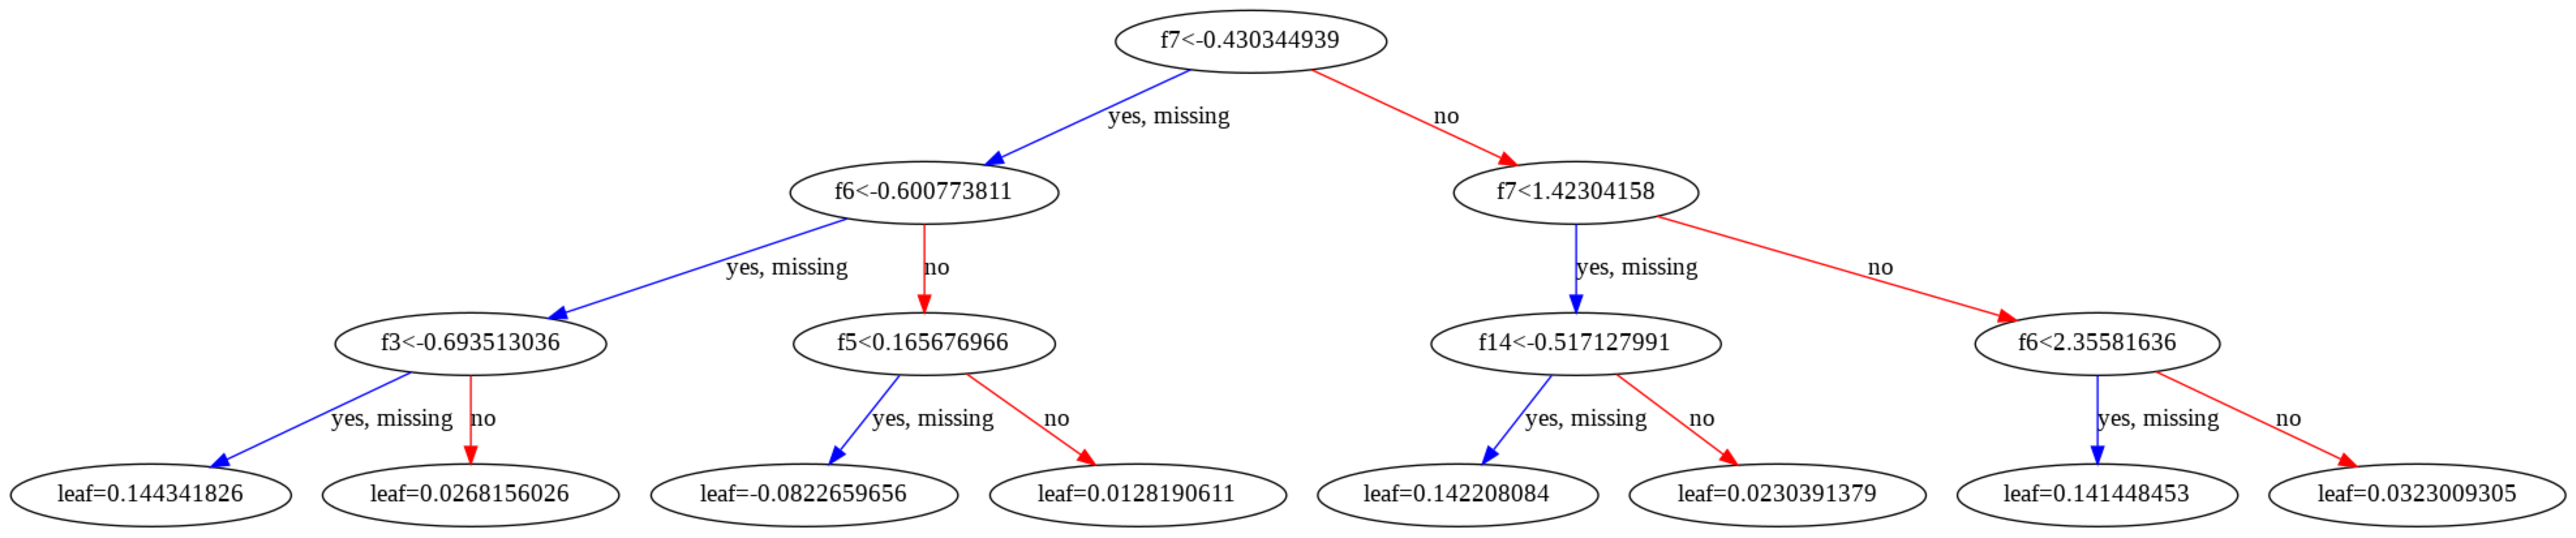

In [ ]:
plt.figure(figsize=(15,10))
plot_tree(xgb,num_trees=4)
plt.show()

In [ ]:
|